In [1]:
import numpy as np
from scipy import ndimage
import tensorflow as tf
from os import listdir

#has package pillow as a dependency. Is needed to give scipy image operations. 
from scipy import misc
import scipy

from modules.utils import *
from modules.model import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
'''Constants'''
IMAGE_FOLDER_c1 = "data/rs_cats"
IMAGE_FOLDER_c2 = "data/s_imagenet"


BATCH_SIZE = 1
EPOCHS = 35

INPUT_SIZE = Dimensions(32, 32)

LEARNING_RATE = 0.001

In [3]:
'''Load data'''
image_names_c1 = listdir(IMAGE_FOLDER_c1)
image_names_c2 = listdir(IMAGE_FOLDER_c2)
image_paths_c1 = [IMAGE_FOLDER_c1 + '/' + name for name in image_names_c1[0:1000]]
image_paths_c2 = [IMAGE_FOLDER_c2 +'/' + name for name in image_names_c2[0:1000]]
print(len(image_paths_c1))
print(len(image_paths_c2))

1000
1000


In [4]:
def discriminator(in_tensor):
    discriminator = Model("Discriminator", in_tensor)
    discriminator.full_conv2d(3,64)
    discriminator.lrelu()
    discriminator.batch_norm()
    discriminator.full_conv2d(64, 64, stride=1)
    discriminator.lrelu()
    discriminator.batch_norm()
    discriminator.full_conv2d(64,128, stride=2)
    discriminator.lrelu()
    discriminator.batch_norm()
    discriminator.full_conv2d(128,128, stride=1)
    discriminator.lrelu()
    discriminator.batch_norm()
    discriminator.full_conv2d(128,256, stride=2)
    discriminator.lrelu()
    discriminator.batch_norm()
    discriminator.full_conv2d(256,256, stride=1)
    discriminator.lrelu()
    discriminator.batch_norm()
    discriminator.full_conv2d(256,256, stride=2)
    discriminator.lrelu()
    discriminator.batch_norm()
    discriminator.full_conv2d(256,256, stride=1)
    discriminator.dense(4096,1024)
    discriminator.lrelu()
    discriminator.dense(1024,2)
    return discriminator

def generator(in_tensor):
    generator = Model("Generator", in_tensor)
    generator.reshape([-1,10,10,3])
    generator.upscale([32,32])
    generator.reshape([-1,32*32*3])
    generator.dense(32*32*3, 32*32*3)
    generator.reshape([-1,32,32,3])
    generator.rgb_bound()
    return generator


In [5]:
try: 
    disc_real_input = tf.placeholder('float32', shape = [None, INPUT_SIZE.h, INPUT_SIZE.w, 3])
    #disc_fake_input = tf.placeholder('float32', shape = [None, INPUT_SIZE.h, INPUT_SIZE.w, 3])
    gen_noise = tf.placeholder('float32', shape = [None, 300])

    #Generator
    gen_noise_image = tf.reshape(gen_noise,[-1,10,10,3])
    generator_model = generator(gen_noise_image)


    #disc_fake_input = generator_model.get_output()
    #Discriminator
    #with tf.variable_scope('disc') as scope:
    #    disc_model_r = discriminator(disc_real_input)
    #    scope.reuse_variables()
    #    disc_model_f = discriminator(disc_fake_input)


    #discriminator loss
    #disc_c1 = tf.nn.sparse_softmax_cross_entropy_with_logits(disc_model_r.get_output(), tf.ones([BATCH_SIZE], tf.int32))
    #disc_c2 = tf.nn.sparse_softmax_cross_entropy_with_logits(disc_model_f.get_output(), tf.zeros([BATCH_SIZE], tf.int32))
    #disc_loss = tf.reduce_mean(disc_c1)+tf.reduce_mean(disc_c2)
    #disc_opt = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(disc_loss, var_list = disc_model_f.variables)

    #generator loss
    #gen_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(disc_model_f.get_output(), tf.ones([BATCH_SIZE], tf.int32))

    flat = tf.reshape(generator_model.outputs[-2], [1,-1])
    ideal = 255*tf.ones_like(flat)
    nLoss = tf.reduce_mean(tf.square(flat - ideal))

    gen_loss = nLoss
    gen_opt = tf.train.AdamOptimizer().minimize(gen_loss)#,var_list = generator_model.variables)
    gen_img = tf.cast(generator_model.get_output(), dtype=tf.uint8)
except: 
    tf.reset_default_graph()
    raise

In [6]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [7]:
image_gen_c1 = minibatch_image_generator(image_paths_c1[0:(len(image_paths_c1)//BATCH_SIZE)*BATCH_SIZE],BATCH_SIZE)
image_gen_c2 = minibatch_image_generator(image_paths_c2[0:(len(image_paths_c2)//BATCH_SIZE)*BATCH_SIZE],BATCH_SIZE)
print("generating images") 
epoch,image_batch = next(image_gen_c1)
epoch,image_batch = next(image_gen_c2)
print("generated images") 

generating images
generated images


In [8]:
#epoch,image_batch_c2 = next(image_gen_c2)
try:
    index = 0
    steps = 4000
    in_noise = np.array([[np.random.rand()*10 for i in range(300)] for i in range(BATCH_SIZE)])  
    while(index < steps):
        index = index + 1
        epoch,image_batch_c1 = next(image_gen_c1)
        fd = {disc_real_input:image_batch_c1, gen_noise:in_noise}
        (_, g_loss) = sess.run([gen_opt, gen_loss], feed_dict = fd)
        if(index % 500 == 0):
            print('step = %-5d disc loss = %-10f gen loss = %-10f' % (index, 0, g_loss))
except KeyboardInterrupt:
    pass #avoids getting KeyboardInterrupt errors when stopping training early
except:
    raise

step = 500   disc loss = 0.000000   gen loss = 0.000000  
step = 1000  disc loss = 0.000000   gen loss = 0.000000  
step = 1500  disc loss = 0.000000   gen loss = 0.000000  
step = 2000  disc loss = 0.000000   gen loss = 0.000000  
step = 2500  disc loss = 0.000000   gen loss = 0.000000  
step = 3000  disc loss = 0.000000   gen loss = 0.000000  
step = 3500  disc loss = 0.000000   gen loss = 0.000000  
step = 4000  disc loss = 0.000000   gen loss = 0.000000  


In [9]:
epoch,image_batch_c1 = next(image_gen_c1)
in_noise = np.array([[np.random.rand()*10 for i in range(300)] for i in range(BATCH_SIZE)])  
fd = {disc_real_input:image_batch_c1, gen_noise:in_noise}
(sample) = sess.run(gen_img,feed_dict={gen_noise: in_noise})

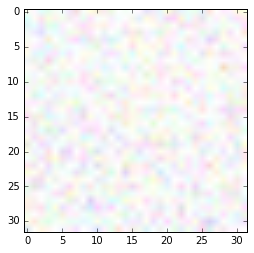

In [11]:
plt.imshow(sample[0])

In [14]:
fd = {disc_real_input:image_batch_c1, gen_noise:in_noise}
sess.run(flat, fd)
#print(sess.run(tf.ones_like(disc_model_r.get_output()), fd))

array([[ 260.26760864,  259.52801514,  272.55093384, ...,  266.47711182,
         244.89204407,  265.94747925]], dtype=float32)